In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
# import Learn_Knonlinear as lka
import scipy
import scipy.linalg
from scipy.integrate import odeint
import sys
import os
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/utility/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/sizeNN_learnmodel_train/")
sys.path.append("D:/毕业设计/中期/Python/MPC_trykoopman/control/SOC_compare/other_model/")
from Utility import data_collecter
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
Method_names = ["KoopmanDerivative","KoopmanRBF",\
            "KDNN","KRNN","DKUC(ours)",\
            "DKAC(ours)","DKN(ours)",\
                ]

In [3]:
def short_predict(method_index,data,net,u_dim=1,Nstate=4):
    steps,train_traj_num,Nstates = data.shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = torch.DoubleTensor(data).to(device)
    X_current = net.encode(data[0,:,u_dim:]).T
    max_loss_list = []
    mean_loss_list = []
    min_loss_list = []
    pre_list = []
    real_list = []
    for i in range(steps-1):
        if method_index==4:
            X_current = net.forward(X_current.T,data[i,:,:u_dim]).T
        elif method_index==5:
            bilinear = net.bicode(X_current[:Nstate,:].T.detach(),data[i,:,:u_dim]).T #detach's problem 
            X_current = net.forward(X_current.T,bilinear.T).T
        elif method_index==6:
            bilinear = net.bicode(X_current[:Nstate,:].T.detach(),data[i,:,:u_dim]).T #detach's problem 
            X_current = net.forward(X_current.T,bilinear.T).T
        Y = data[i+1,:,u_dim:]
        Err = X_current[:Nstate,:].T-Y
        print(torch.mean(X_current[:Nstate,:].T,axis=0)[0],torch.mean(Y,axis=0)[0])
        # print(Y.shape)
        pre_list.append(np.array(torch.mean(X_current[:Nstate,:].T,axis=0).detach().cpu().numpy()))
        # print(torch.mean(X_current[:Nstate,:].T,axis=0).shape)
        real_list.append(np.array(torch.mean(Y,axis=0).detach().cpu().numpy()))
        max_loss_list.append(torch.mean(torch.max(torch.abs(Err),axis=0).values).detach().cpu().numpy())
        mean_loss_list.append(torch.mean(torch.mean(torch.abs(Err),axis=0)).detach().cpu().numpy())
        min_loss_list.append(torch.mean(torch.min(torch.abs(Err),axis=0).values).detach().cpu().numpy())
    print(np.array(pre_list)[:,0], np.array(real_list)[:,0])
    print(np.array(mean_loss_list))
    return np.array(max_loss_list),np.array(mean_loss_list),np.array(min_loss_list),np.array(pre_list),np.array(real_list)

In [4]:
def mean_predict(suffix,env_name,method_index,layer_i,steps):
    # method_index = 0
    method = Methods[method_index]
    root_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+suffix
    print(method)
    #sys.path.append("control/train/")
    if  method.endswith("KNonlinearRNN"):
        import Learn_Knonlinear_RNN as lka
    elif method.endswith("KNonlinear"):
        import Learn_Knonlinear as lka
    elif method.endswith("KoopmanNonlinear"):
        import learn_DKN_SOC_sizeNN as lka
    elif method.endswith("KoopmanNonlinearA"):
        import learn_DKAC_SOC_sizeNN as lka
    elif method.endswith("KoopmanU"):
        import learn_DKUC_SOC_sizeNN as lka
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name+"layer{}".format(layer_i)+"_") and file.endswith(".pth"):
            model_path = file  
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstates = Data_collect.Nstates
    layer_depth = layer_i
    layer_width = 128
    dicts = torch.load(root_path+"/"+model_path,map_location=torch.device('cpu'))
    state_dict = dicts["model"]
    if method.endswith("KNonlinear"):
        Elayer = dicts["Elayer"]
        net = lka.Network(layers=Elayer,u_dim=udim)
    elif method.endswith("KNonlinearRNN"):
        net = lka.Network(input_size=udim+Nstates,output_size=Nstates,hidden_dim=layer_width, n_layers=layer_depth-1)
    elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
        layer = dicts["layer"]
        blayer = dicts["blayer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,blayer,NKoopman,udim)
    elif method.endswith("KoopmanU"):
        layer = dicts["layer"]
        NKoopman = layer[-1]+Nstates
        net = lka.Network(layer,NKoopman,udim)  
    net.load_state_dict(state_dict)
    #device = torch.device("cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.cuda()
    net.double()
    Samples = 1
    steps = steps
    random.seed(2022)
    np.random.seed(2022)
    times = 1
    pre_list_all = np.zeros((times,steps,Nstates))
    rea_list_all = np.zeros((times,steps,Nstates))
    with torch.no_grad():
        for i in range(times):
            # test_data_path = "D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/"+"method{}{}.npy".format(env_name,i)
            # if os.path.exists(test_data_path):
            #     test_data = np.load("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_compare_sizeNNdata/{}{}.npy".format(env_name,i))
            # else:
            test_data = Data_collect.collect_koopman_data(Samples,steps)
            np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_short_predict_data/"+"method{}{}.npy".format(env_name,i),test_data)
            _,_,_,pre_list,rea_list = short_predict(method_index,test_data,net,udim,Nstate=Nstates)
            #print(pre_list.shape)
            pre_list_all = pre_list
            rea_list_all = rea_list
    pre_list_mean = pre_list_all#np.mean(pre_list_all,axis=0)
    rea_list_mean = rea_list_all#np.mean(rea_list_all,axis=0)  
    np.save("D:/毕业设计/中期/Python/MPC_trykoopman/results/SOC_short_predict_data/"+env_name+"_"+method+"layer1{}{}.npy".format(layer_i, steps),np.array([pre_list_mean, rea_list_mean]))
    np.save("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-pre-long{}.npy".format(steps),pre_list_mean)
    np.save("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-real-long{}.npy".format(steps),rea_list_mean)
    return pre_list_mean, rea_list_mean

<>:68: DeprecationWarning: invalid escape sequence \P


In [24]:
#suffix = "compare_DKAC_sizeNN_30"
#suffix = "DKUC_SOC_sizeNN"
#suffix = "DKN_SOC_sizeNN"
suffix = ["*","*","Knolinear_SOC_models","KRNN_SOC_models","DKUC_SOC_sizeNN","compare_DKAC_sizeNN_30","DKN_SOC_sizeNN"]
env_name = "DampingPendulum"
#env_name = "MountainCarContinuous-v0"
# env_name = "CartPole-v1"
# env_name = "Pendulum-v1"
steps = 10000
for i in range(6,7):
    pre_list_mean, rea_list_mean = mean_predict(suffix[i],env_name,method_index=i,layer_i=2,steps=steps)
    print(pre_list_mean.shape)

KoopmanNonlinear
tensor(0.3771, device='cuda:0', dtype=torch.float64) tensor(0.3771, device='cuda:0', dtype=torch.float64)
tensor(0.3543, device='cuda:0', dtype=torch.float64) tensor(0.3542, device='cuda:0', dtype=torch.float64)
tensor(0.3295, device='cuda:0', dtype=torch.float64) tensor(0.3293, device='cuda:0', dtype=torch.float64)
tensor(0.3013, device='cuda:0', dtype=torch.float64) tensor(0.3012, device='cuda:0', dtype=torch.float64)
tensor(0.2717, device='cuda:0', dtype=torch.float64) tensor(0.2716, device='cuda:0', dtype=torch.float64)
tensor(0.2422, device='cuda:0', dtype=torch.float64) tensor(0.2422, device='cuda:0', dtype=torch.float64)
tensor(0.2135, device='cuda:0', dtype=torch.float64) tensor(0.2136, device='cuda:0', dtype=torch.float64)
tensor(0.1862, device='cuda:0', dtype=torch.float64) tensor(0.1864, device='cuda:0', dtype=torch.float64)
tensor(0.1605, device='cuda:0', dtype=torch.float64) tensor(0.1607, device='cuda:0', dtype=torch.float64)
tensor(0.1366, device='cuda:0

Text(0.5, 1.0, 'DampingPendulum')

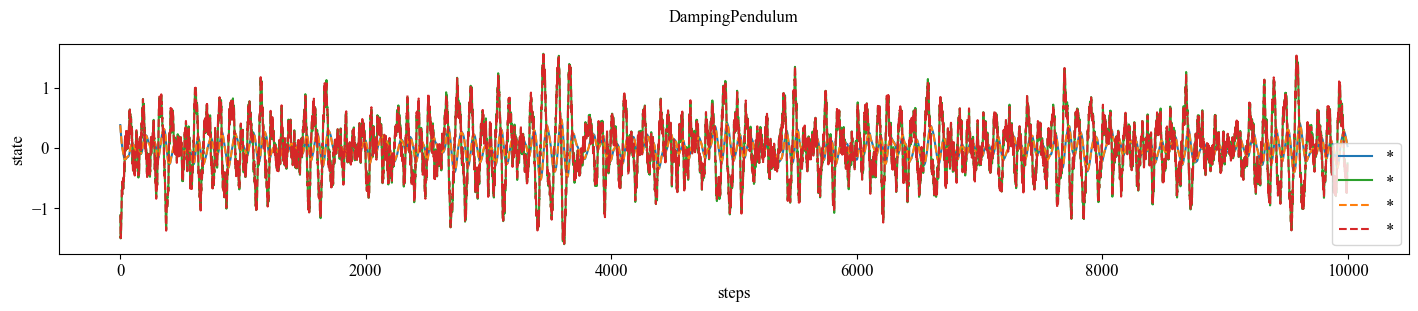

In [25]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3
labels = ["*","*","BaseNet","KoopmanRNN","SDKN-DKUC","SDKN-DKAC","SDKN-DKN"]
plt.figure(figsize=(15, 3))
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = env_name
title = env_name
compare = "mean"
T = []
for t in range(steps):
    T.append(t+1)
T = np.array(T)
for i in range(1):
    pre_data = pre_list_mean
    real_data = rea_list_mean
    #print(data.shape)
    plt.plot(T,pre_data[:,0],'-',color = colors[i],label=labels[i])#np.log10(data)
    plt.plot(T,pre_data[:,1],'-',color = colors[i+2],label=labels[i])#np.log10(data)
    plt.plot(T,real_data[:,0],'--',color = colors[i+1],label=labels[i])#np.log10(data)
    plt.plot(T,real_data[:,1],'--',color = colors[i+3],label=labels[i])#np.log10(data)
    # plt.plot(T,pre_data[:,2],'-',color = colors[i],label=labels[i])#np.log10(data)
    # plt.plot(T,pre_data[:,3],'-',color = colors[i+2],label=labels[i])#np.log10(data)
    # plt.plot(T,real_data[:,2],'--',color = colors[i+1],label=labels[i])#np.log10(data)
    # plt.plot(T,real_data[:,3],'--',color = colors[i+3],label=labels[i])#np.log10(data)
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
plt.legend(loc = 'lower right')
plt.grid(False)
plt.xlabel("steps",fontsize=12)
plt.ylabel("state",fontsize=12)
# plt.ylim([-2,1])
# plt.yticks([])
plt.title(env_name,fontsize=12)
#plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/steps{}".format(steps)+env_name+"_models_"+compare+"_new1.png",dpi=500)

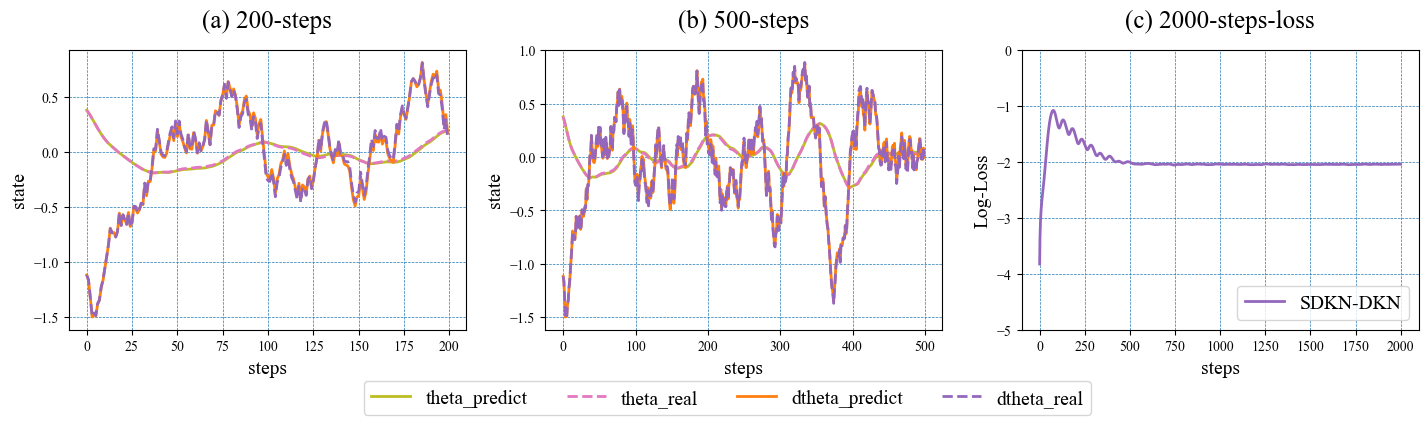

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 3
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.top'] = 0.9 #子视图大小占视图的比例
plt.rcParams['savefig.dpi'] = 500 #图片像素
T = []
for t in range(30):
    T.append(t+1)
T = np.array(T)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
env_name = "DampingPendulum"
pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-pre-long200.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-real-long200.npy")
ax[0].plot(pre_data[:,0],'-', color = colors[8], label="theta_predict")
ax[0].plot(real_data[:,0],'--', color = colors[6], label="theta_real")
ax[0].plot(pre_data[:,1],'-', color = colors[1], label="dtheta_predict")
ax[0].plot(real_data[:,1],'--', color = colors[4], label="dtheta_real")
# ax[0].plot(T,pre_data[:,2],'-', color = colors[1], label="x3_predict")
# ax[0].plot(T,real_data[:,2],'--', color = colors[0], label="x3_real")
# ax[0].plot(T,pre_data[:,3],'-', color = colors[3], label="x4_predict")
# ax[0].plot(T,real_data[:,3],'--', color = colors[2], label="x4_real")
ax[0].set_xlabel("steps",fontsize=14)
ax[0].set_ylabel("state",fontsize=14)
# ax[0].set_yticks([])
ax[0].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
ax[0].set_title("(a) 200-steps",fontsize=18)

pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-pre-long500.npy")
real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-real-long500.npy")
ax[1].plot(pre_data[:,0],'-', color = colors[8], label="theta_predict")
ax[1].plot(real_data[:,0],'--', color = colors[6], label="theta_real")
ax[1].plot(pre_data[:,1],'-', color = colors[1], label="dtheta_predict")
ax[1].plot(real_data[:,1],'--', color = colors[4], label="dtheta_real")
# ax[1].plot(T,pre_data[:30,2],'-', color = colors[1], label="x3_predict")
# ax[1].plot(T,real_data[:30,2],'--', color = colors[0], label="x3_real")
# ax[1].plot(T,pre_data[:30,3],'-', color = colors[3], label="x4_predict")
# ax[1].plot(T,real_data[:30,3],'--', color = colors[2], label="x4_real")
ax[1].set_xlabel("steps",fontsize=14)
ax[1].set_ylabel("state",fontsize=14)
# ax[1].set_yticks([])
ax[1].set_title("(b) 500-steps",fontsize=18)
ax[1].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
ax[1].legend(bbox_to_anchor=(1.4,-0.15), ncol=10 ,fontsize=14)#,loc='lower right'

loss_data1 = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/"+env_name+"_"+"KoopmanNonlinear"+"2000.npy")
#loss_data2 = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/5.5-loss.npy")
#ax[2].plot(T,np.log10(loss_data1[:30,0]),'*-', color = colors[8], label="SDKN-DKUC")
ax[2].plot(np.log10(loss_data1[2]),'-', color = colors[4], label="SDKN-DKN")
ax[2].set_xlabel("steps",fontsize=14)
ax[2].set_ylabel("Log-Loss",fontsize=14)
ax[2].set_ylim([-5,0])
ax[2].set_title("(c) 2000-steps-loss",fontsize=18)
ax[2].grid(True, linestyle='--', color=colors[0], linewidth=0.5)
ax[2].legend(loc='lower right',fontsize=14)

#plt.suptitle("DampingPendulum",fontsize=16)#,x=0.5,y=0.7
#plt.legend(bbox_to_anchor=(-0.7, -0.3), loc='lower center', ncol=10 ,fontsize=12)#bbox_to_anchor=(-0.7, -0.4),
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"SDKN-DKN-LONG.png")
plt.show()

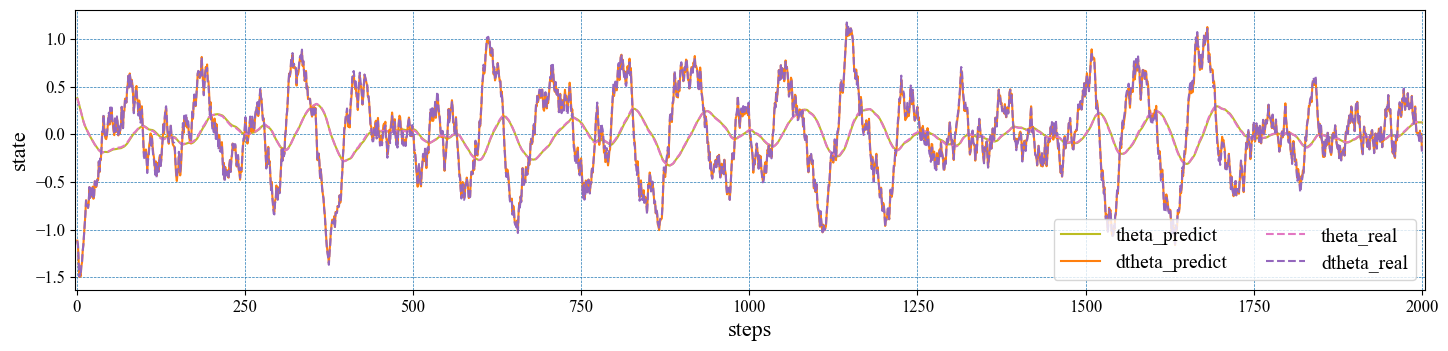

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
font = {'size': 12}
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams["axes.titlepad"] = 16
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 3
labels = ["*","*","BaseNet","KoopmanRNN","SDKN-DKUC","SDKN-DKAC","SDKN-DKN"]
plt.figure(figsize=(15, 4))
plt.rc('font', **font)
# markers = ['*','+','*','+','*','+','*']
env_name = "DampingPendulum"
title = env_name
compare = "mean"
T = []
for t in range(2000):
    T.append(t+1)
T = np.array(T)
for i in range(1):
    pre_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-pre-long2000.npy")
    real_data = np.load("D:/毕业设计/中期\Python/MPC_trykoopman/control/SOC_compare/short_predict_data/6.2-real-long2000.npy")
    #print(data.shape)
    plt.plot(T,pre_data[:,0],'-',color = colors[8],label="theta_predict")#np.log10(data)
    plt.plot(T,pre_data[:,1],'-',color = colors[1],label="dtheta_predict")#np.log10(data)
    plt.plot(T,real_data[:,0],'--',color = colors[6],label="theta_real")#np.log10(data)
    plt.plot(T,real_data[:,1],'--',color = colors[4],label="dtheta_real")#np.log10(data)
    # plt.plot(T,pre_data[:,2],'-',color = colors[i],label=labels[i])#np.log10(data)
    # plt.plot(T,pre_data[:,3],'-',color = colors[i+2],label=labels[i])#np.log10(data)
    # plt.plot(T,real_data[:,2],'--',color = colors[i+1],label=labels[i])#np.log10(data)
    # plt.plot(T,real_data[:,3],'--',color = colors[i+3],label=labels[i])#np.log10(data)
    # 每隔10个数据点添加一个标记
    #marked_indices = np.arange(0, steps, 50)
    #plt.scatter(T[marked_indices], np.log10(data[2])[marked_indices], c=colors[i], marker='*')
plt.legend(loc = 'lower right', ncol=2 ,fontsize=14)
plt.grid(True, linestyle='--', color=colors[0], linewidth=0.5)
plt.xlabel("steps",fontsize=16)
plt.ylabel("state",fontsize=16)
plt.xlim([-2,2005])
# plt.yticks([])
#plt.title(env_name,fontsize=1)
plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/short/"+"SDKN-DKN-LONG-2000.png",dpi = 500)
#plt.savefig("D:/毕业设计/论文/pictures/SOC_short_predict/steps{}".format(steps)+env_name+"_models_"+compare+"_new1.png",dpi=500)